In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

- [ ] Предобработка данных
- [ ] Анализ данных о регистрациях и займах
- [ ] Сколько времени проходит с момента начала регистрации до оформления первого займа
- [ ] Срок займа: план-факт + динамика
- [ ] Категоризация займов по реальному сроку пользования деньгами
- [ ] Исследование суммы займов
- [ ] Когортный анализ:
    - [ ] User Retention
    - [ ] Ср.кол-во займов нарастающим итогом
    - [ ] Ср.сумма займа нарастающим итогом
    - [ ] ARPU
    - [ ] Ретеншен капитала
    - [ ] NPL

## Чтение данных и объединение таблиц с данными о регистрациях

In [2]:
# читаем данные
regs = pd.read_excel('regs.xlsx')
loans = pd.read_excel('loans.xlsx')

## Предобработка данных

### Регистрации

In [3]:
# посмотрим на общую информацию
regs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 557663 entries, 0 to 557662
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   cid              557663 non-null  int64         
 1   reg_date         557663 non-null  datetime64[ns]
 2   is_reg_complete  557663 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 12.8 MB


In [4]:
# изучим срез данных
regs.sample(5)

,cid,reg_date,is_reg_complete
388274,1304895,2020-01-28,1
154081,1047312,2019-04-15,0
322208,1232700,2019-11-01,1
460845,1377661,2020-07-21,1
224226,1125101,2019-06-06,0


<b>cid</b> - id клиента<br>
<b>reg_date</b> - дата начала регистрации<br>
<b>is_reg_complete</b> - отметка о завершени регистрации<br>

In [5]:
# проверим таблицу на наличие пропусков и дубликатов
display(regs.isna().sum())
display(regs.duplicated().sum())

cid                0
reg_date           0
is_reg_complete    0
dtype: int64

0

<div class="alert alert-block alert-success">
<b>Вывод:</b> пропусков и дублей нет, двигаемся дальше
</div>

### Займы

In [6]:
# посмотрим на общую информацию
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104964 entries, 0 to 104963
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   cid         104964 non-null  int64         
 1   start_date  96140 non-null   datetime64[ns]
 2   value       104964 non-null  float64       
 3   term        104964 non-null  int64         
 4   status      104964 non-null  object        
 5   end_date    62100 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
# изучим срез данных
loans.sample(5)

,cid,start_date,value,term,status,end_date
63208,1231360,NaT,3500.0,30,Отменён,NaT
57052,1199315,2019-08-13,12840.0,40,Погашен,2019-09-26
35382,1059497,2019-04-19,12000.0,30,Погашен,2019-05-19
26357,1006016,2019-04-11,6500.0,30,Погашен,2019-09-19
25993,1002289,2019-03-16,5300.0,23,Погашен,2019-04-07


In [8]:
# проверим таблицу на наличие пропусков и дубликатов
display(loans.isna().sum())
display(loans.duplicated().sum())

cid               0
start_date     8824
value             0
term              0
status            0
end_date      42864
dtype: int64

2194

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <li> нужно избавиться от пропусков в столбце start_date тк займ без даты начала не имеет для нас ценности
    <li> с пропусками в end_date ничего делать будем
    <li> также избавимся от дублей
</div>

In [9]:
# удаляем дубли из столбца start_date
loans.dropna(subset=['start_date'], inplace=True)

# проверяем
display(loans.isna().sum())
display(loans.duplicated().sum())

cid               0
start_date        0
value             0
term              0
status            0
end_date      34040
dtype: int64

0

<div class="alert alert-block alert-success">
<b>Вывод:</b> этап предобработки завершен, переходим к анализу
</div>

## Аналитика данных

### 1. Анализ данных о регистрациях и займах. Динамика по времени, конверсия + графики

Нам нужна таблица, в которой будут данные в динамике по месяцам:
- Общее кол-во регистраций
- Кол-во успешных (завершенных) регистраций
- Общее кол-во займов
- Кол-во новых займов
- Кол-во повторных займов

#### 1.1 Групиировка данных о регистарциях

In [10]:
# добавим в таблицу regs столбцы: date, week, month - день, неделя и месяц регистрации
regs['reg_month'] = regs['reg_date'].astype('datetime64[M]')

# проверяем
regs.sample(5)

,cid,reg_date,is_reg_complete,reg_month
105615,997673,2019-03-12,1,2019-03-01
112222,1004285,2019-03-18,1,2019-03-01
529741,1448575,2020-10-27,1,2020-10-01
286119,1192135,2019-08-05,1,2019-08-01
373951,1288555,2020-01-09,0,2020-01-01


In [11]:
# сгруппируем данные по месяцам, посчитаем общее кол-во регистраци и кол-во успешных регистраций
regs_by_month = regs.groupby(by='reg_month').agg({'cid': 'nunique', 'is_reg_complete': 'sum'})
regs_by_month.columns = ['total_regs', 'success_regs']

# смотрим
regs_by_month

,total_regs,success_regs
reg_month,,
2019-01-01,40734,34703
2019-02-01,48637,41849
2019-03-01,41833,35433
2019-04-01,42527,31513
2019-05-01,42569,31016
2019-06-01,34171,24573
2019-07-01,33755,24873
2019-08-01,10708,8377
2019-09-01,5168,4245


#### 1.2 Групиировка данных о займах

In [12]:
# у нас уже есть сгруппированные по месяцам данные о регистрациях, теперь тоже самое нужно сделать с займами
# но для начала - добавить в таблицу loans столбцы: date, week, month - день, неделя и месяц регистрации

loans['loan_month'] = loans['start_date'].astype('datetime64[M]')

# проверяем
loans.sample(5)

,cid,start_date,value,term,status,end_date,loan_month
95137,1420197,2020-12-15,25000.0,42,Активен,NaT,2020-12-01
52524,1178273,2019-08-02,3000.0,10,Погашен,2019-08-05,2019-08-01
10110,923754,2019-01-27,8000.0,30,Погашен,2019-01-27,2019-01-01
60637,1212263,2019-10-17,4440.0,30,Отменён,NaT,2019-10-01
94003,1414972,2020-09-14,15000.0,42,Погашен,2020-10-26,2020-09-01


In [13]:
# для начала для каждого юзера найдем месяц первого займа
new_loans_by_month = loans.sort_values(by=['cid', 'start_date']).groupby(by='cid').agg({'loan_month': 'first'}).reset_index()

# теперь сгруппируем данные по месяцам и подсчитаем кол-во уникальны займов
new_loans_by_month = new_loans_by_month.groupby(by='loan_month').agg({'cid': 'count'})
new_loans_by_month.columns = ['new_loans']

# проверяем
new_loans_by_month

,new_loans
loan_month,
2019-01-01,4575
2019-02-01,5018
2019-03-01,3007
2019-04-01,3092
2019-05-01,2520
2019-06-01,1421
2019-07-01,3264
2019-08-01,1878
2019-09-01,1366


In [14]:
# теперь посчитаем общее кол-во займов по месяцам
total_loans_by_month = loans.groupby(by='loan_month').agg({'cid': 'count'})
total_loans_by_month.columns = ['total_loans']

# проверяем
total_loans_by_month

,total_loans
loan_month,
2019-01-01,5487
2019-02-01,7228
2019-03-01,6281
2019-04-01,5915
2019-05-01,5058
2019-06-01,3328
2019-07-01,4884
2019-08-01,3541
2019-09-01,3090


In [15]:
# объеденим таблицы total_loans_by_month и new_loans_by_month
loans_by_month = pd.merge(total_loans_by_month, new_loans_by_month, on='loan_month')

# рассчитаем кол-во повторных займов
loans_by_month['repeated_loans'] = loans_by_month['total_loans'] - loans_by_month['new_loans']

# проверяем
loans_by_month

,total_loans,new_loans,repeated_loans
loan_month,,,
2019-01-01,5487,4575,912
2019-02-01,7228,5018,2210
2019-03-01,6281,3007,3274
2019-04-01,5915,3092,2823
2019-05-01,5058,2520,2538
2019-06-01,3328,1421,1907
2019-07-01,4884,3264,1620
2019-08-01,3541,1878,1663
2019-09-01,3090,1366,1724


#### 1.3 Объеденение данных в обну таблицу

In [16]:
total_grouped_data = pd.merge(regs_by_month, loans_by_month, left_index=True, right_index=True)

total_grouped_data

,total_regs,success_regs,total_loans,new_loans,repeated_loans
2019-01-01,40734,34703,5487,4575,912
2019-02-01,48637,41849,7228,5018,2210
2019-03-01,41833,35433,6281,3007,3274
2019-04-01,42527,31513,5915,3092,2823
2019-05-01,42569,31016,5058,2520,2538
2019-06-01,34171,24573,3328,1421,1907
2019-07-01,33755,24873,4884,3264,1620
2019-08-01,10708,8377,3541,1878,1663
2019-09-01,5168,4245,3090,1366,1724
2019-10-01,21147,16967,2383,1319,1064


#### 1.4 Визуализация

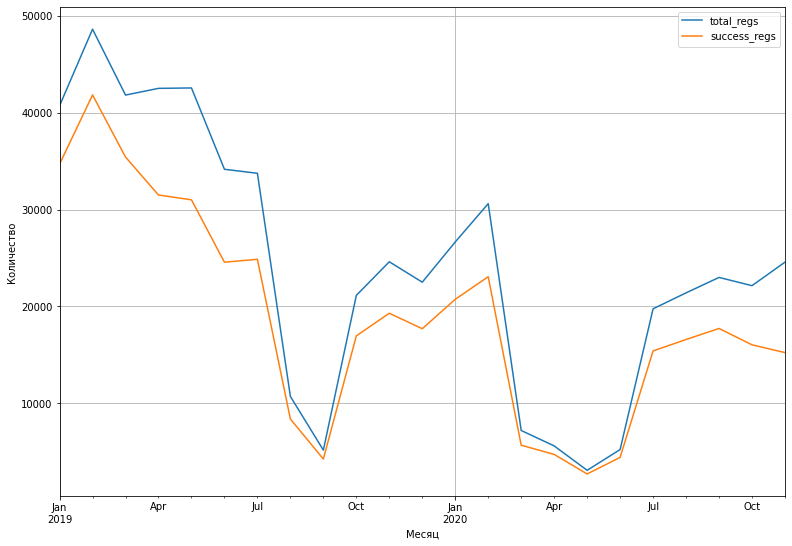

In [17]:
# динамика регистраций по месяцам
total_grouped_data[['total_regs', 'success_regs']].plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество');

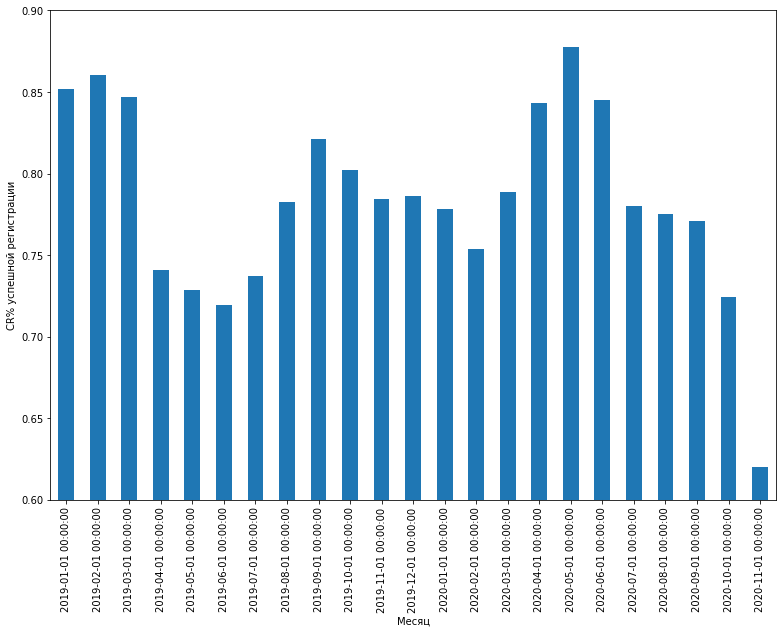

In [18]:
# динамика конверсии из все регистраций в успешные по месяцам
(total_grouped_data['success_regs'] / total_grouped_data['total_regs']).plot(figsize=(13, 9), kind='bar');
plt.ylim(0.6, 0.9)
plt.xlabel('Месяц');
plt.ylabel('CR% успешной регистрации');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> в динамике регистраций не наблюдается какой-то зависимости или сезонности. Есть 2 просадки в период отключения трафика и не более
        <li> конверсия из регистрации в успешную регистрацию также меняется и нахоидся на уровне ~75-78%. Много это или мало - сказать сложно.
    </ul>
</div>

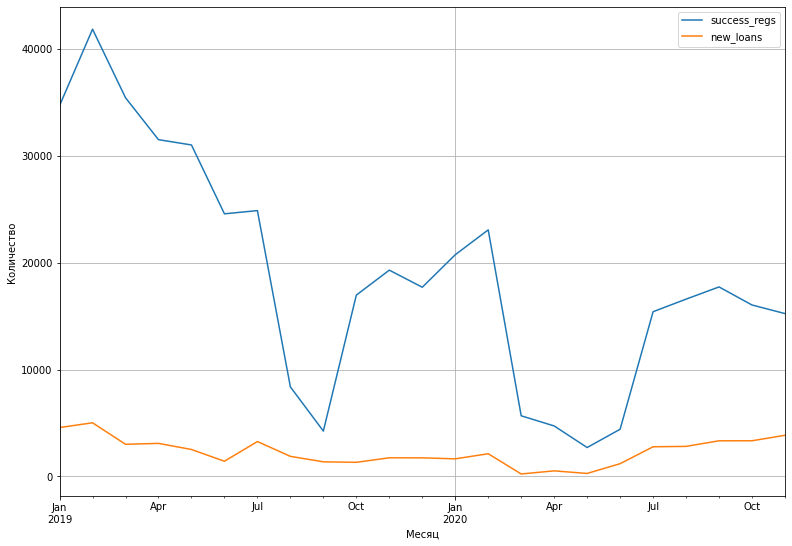

In [19]:
# теперь на одном графике сравним динамику успешных регистраций и новых займов
total_grouped_data[['success_regs', 'new_loans']].plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество');

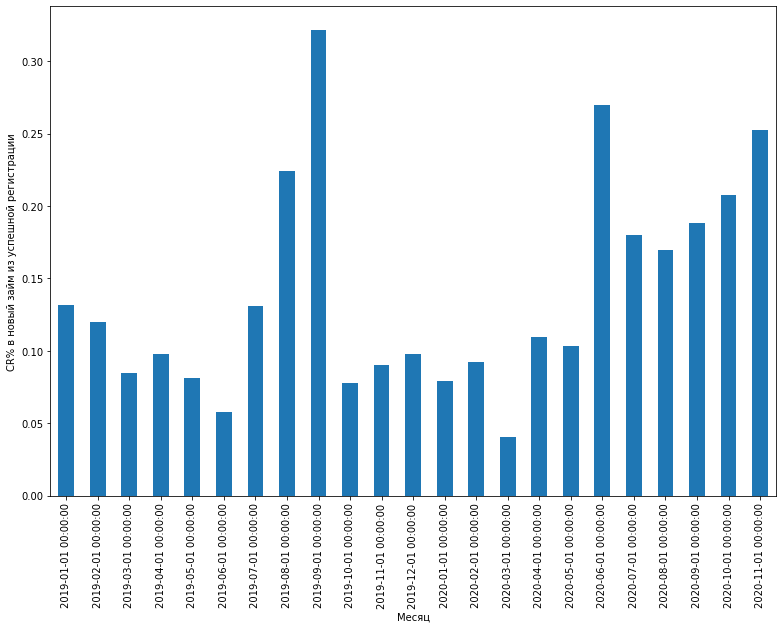

In [20]:
# а также посмотрим на конверсию в динамике
(total_grouped_data['new_loans'] / total_grouped_data['success_regs']).plot(figsize=(13, 9), kind='bar');
plt.xlabel('Месяц');
plt.ylabel('CR% в новый займ из успешной регистрации');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> из-за хаотичных провалов в кол-ве регистраций какую-то связь с выданными новыми займами сложно выделить
        <li> в последние 6 месяцев анализируемого периода конверсия находится на х1.5-2 от уровня предыдущего периода
    </ul>
</div>

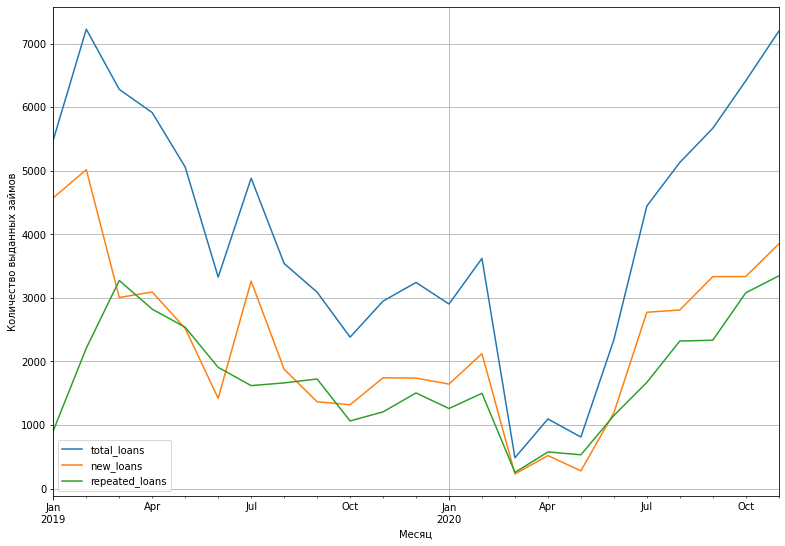

In [21]:
# посмотрим на долю разных типов займов в динамике
total_grouped_data[['total_loans', 'new_loans', 'repeated_loans']].plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество выданных займов');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> с начала 2019 и до начала мая 2020 показатели постепенно снижались
        <li> с мая 2020 наблюдается стабильный рост показателей как новых так и повторных выдач
        <li> доля повторных займов составляет около 45% (мало?)
    </ul>
</div>

### 2. Сколько времени проходит с момента начала регистрации до оформления первого займа

In [22]:
# для начала из таблицы loans нам нужно получить для каждого юзера данные о его первом займе
first_loan_ts = loans.sort_values(by=['cid', 'start_date']).groupby(by='cid').agg({'start_date': 'first'}).reset_index()
first_loan_ts.columns=['cid', 'first_loan_date']

# проверяем
first_loan_ts.head()

,cid,first_loan_date
0,888862,2019-01-01
1,888868,2019-01-01
2,888872,2019-01-12
3,888882,2019-01-01
4,888884,2019-01-01


In [23]:
# теперь добавим эти данные в таблицу с регистрациями
time_to_loan = pd.merge(regs, first_loan_ts, how='left', on='cid')

# посмотрим на случайные 20 записей из получившейся таблицы
time_to_loan.sample(20)

,cid,reg_date,is_reg_complete,reg_month,first_loan_date
328809,1239325,2019-11-09,1,2019-11-01,NaT
317446,1227924,2019-10-28,1,2019-10-01,NaT
520922,1439756,2020-10-13,1,2020-10-01,NaT
192585,1091896,2019-05-20,0,2019-05-01,NaT
439819,1356604,2020-05-13,1,2020-05-01,2020-05-29
208925,1108883,2019-05-27,1,2019-05-01,NaT
338290,1248855,2019-11-20,1,2019-11-01,NaT
55333,945251,2019-02-08,1,2019-02-01,NaT
453431,1370247,2020-07-12,0,2020-07-01,NaT
40109,930022,2019-01-31,1,2019-01-01,NaT


<div class="alert alert-block alert-info">
<b>Важно:</b> во многих строках столбца start_loan появились значения NaT. Это говорит о том, что клиент начал регистрацию, но в итоге ни одного займа не получил. Избавимся от этих строк</div>

In [24]:
# удаляем лишние строки
time_to_loan.dropna(subset=['first_loan_date'], inplace=True)

In [25]:
# добавим в таблицу новый столбец с кол-во дней с начала регистрации до первого займа
time_to_loan['days_to_loan'] = (time_to_loan['first_loan_date'] - time_to_loan['reg_date']).dt.days

time_to_loan.sample(10)

,cid,reg_date,is_reg_complete,reg_month,first_loan_date,days_to_loan
151103,1044100,2019-04-13,1,2019-04-01,2019-11-29,230
170192,1066774,2019-04-25,1,2019-04-01,2019-09-20,148
149393,1042251,2019-04-12,1,2019-04-01,2019-04-12,0
280408,1186228,2019-07-27,1,2019-07-01,2019-07-27,0
411815,1328501,2020-02-13,1,2020-02-01,2020-02-13,0
69832,961753,2019-02-16,1,2019-02-01,2019-02-16,0
362641,1275219,2019-12-24,1,2019-12-01,2019-12-24,0
35355,925239,2019-01-28,1,2019-01-01,2019-01-28,0
240736,1142649,2019-06-21,1,2019-06-01,2019-08-29,69
553202,1472051,2020-11-24,1,2020-11-01,2020-11-24,0


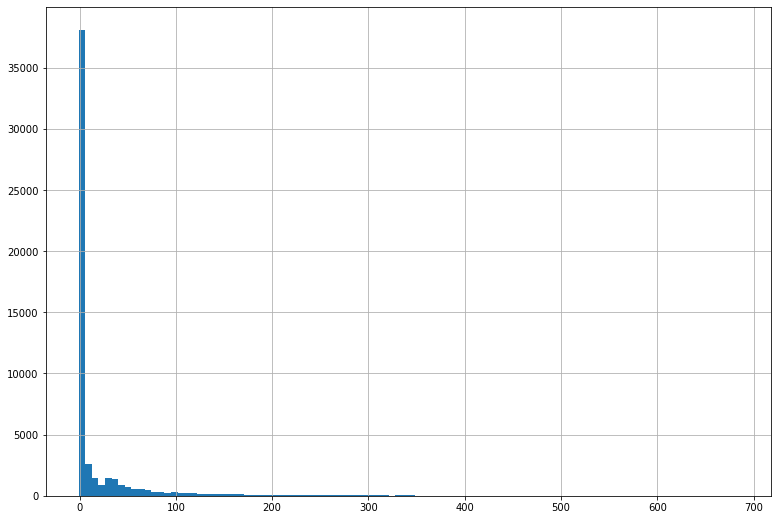

In [26]:
# построим гистограмму
time_to_loan['days_to_loan'].hist(figsize=(13, 9), bins=100);

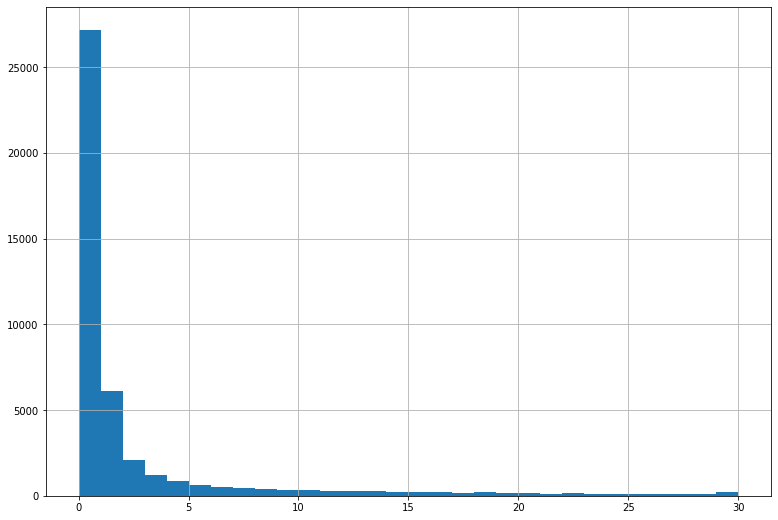

In [27]:
# львиная доля значений лежит в диапазоне от 0 до 30 дней, ограничим гистограмму этими значениями
time_to_loan['days_to_loan'].hist(figsize=(13, 9), bins=30, range=(0, 30));

In [28]:
# посмотрим на ТОП10 значений
time_to_loan['days_to_loan'].value_counts().head(10)

0     27170
1      6094
2      2083
3      1214
4       870
5       646
6       516
7       430
31      407
8       382
Name: days_to_loan, dtype: int64

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>львиная доля клиентов получают свой первый заем в день регистрации
        <li>кол-во выдач на следующий день относительно большое, но это в т.ч. может быть связано с займами, которые оформляются в вечернее время и выдаются уже на следующий день
        <li>есть небольшой скачок на 31 день. Скорее всего это связано с разблокировкой спустя 30 дней
        <li>чем дальше от времени регистрации тем меньше шанс, что клиент оформит свой первый заем
        <li>в качестве рекомендации - нужно стараться максимально быстро конвертировать регистрацию в первый заем
    </ul>
</div>

### 3. Исследвание срока займа (план, факт) + динамика по месяцам

#### 3.1 Запрашиваемые и фактические значения займов

In [29]:
# рассчитаем фактический срок пользования деньгами
loans['real_term'] = (loans['end_date'] - loans['start_date']).dt.days

# удалим пустые значения т.к. нам нужны только те займы, которые уже погашены и сохраним данные в отдельный датафрейм
real_term = loans.query('real_term.notna()')
real_term['real_term'] = real_term['real_term'].astype('int')

# проверим на выборке
real_term.sample(10)

,cid,start_date,value,term,status,end_date,loan_month,real_term
102198,1458752,2020-11-08,5000.0,12,Погашен,2020-11-19,2020-11-01,11
26778,1009095,2019-04-09,20000.0,25,Погашен,2019-05-07,2019-04-01,28
17780,958773,2019-02-15,6500.0,16,Погашен,2019-04-26,2019-02-01,70
32192,1041939,2020-02-22,2600.0,25,Погашен,2020-03-15,2020-02-01,22
17125,955763,2019-02-12,9800.0,23,Погашен,2019-03-29,2019-02-01,45
90926,1399727,2020-10-31,2000.0,12,Погашен,2020-11-05,2020-10-01,5
39597,1086924,2019-08-10,8000.0,40,Погашен,2019-10-09,2019-08-01,60
73149,1308614,2020-01-30,19000.0,56,Погашен,2020-02-27,2020-01-01,28
60431,1210899,2020-07-30,16500.0,29,Погашен,2020-08-02,2020-07-01,3
16011,949869,2019-02-11,2500.0,30,Погашен,2019-03-24,2019-02-01,41


In [30]:
# сравним сумму дней из запросов пользователей с суммой фактических дней пользования кредитом
print(f'Всего займов было оформлено на {real_term["term"].sum():,} дня(ей)')
print(f'Фактически, с учетом досрочных погашений и просрочек деньгами пользовались {real_term["real_term"].sum():,} дня(ей)')

Всего займов было оформлено на 1,787,431 дня(ей)
Фактически, с учетом досрочных погашений и просрочек деньгами пользовались 2,157,463 дня(ей)


<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> Суммарный фактичесий срок пользования деньгами на 21% (или 862,699 дней) больше, чем все суммарные запрошенные значения. Это даже с учетом займов, которые погашаются досрочно (спойлер: их достаточно много)
    </ul>
</div>

#### 3.2 Распределение показателей, среднее значение, медиана, мода

count    62100.000000
mean        28.783108
std         14.231329
min          1.000000
25%         19.000000
50%         30.000000
75%         39.000000
max        168.000000
Name: term, dtype: float64

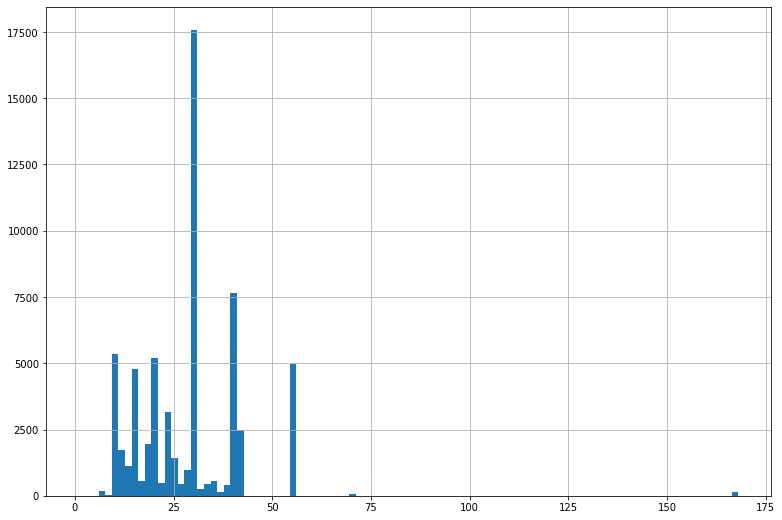

In [31]:
# распределение запрашиваемых сроков займов
display(real_term['term'].describe())
real_term['term'].hist(bins=100, figsize=(13, 9));

count    62100.000000
mean        34.741755
std         40.269166
min          0.000000
25%         10.000000
50%         23.000000
75%         43.000000
max        666.000000
Name: real_term, dtype: float64

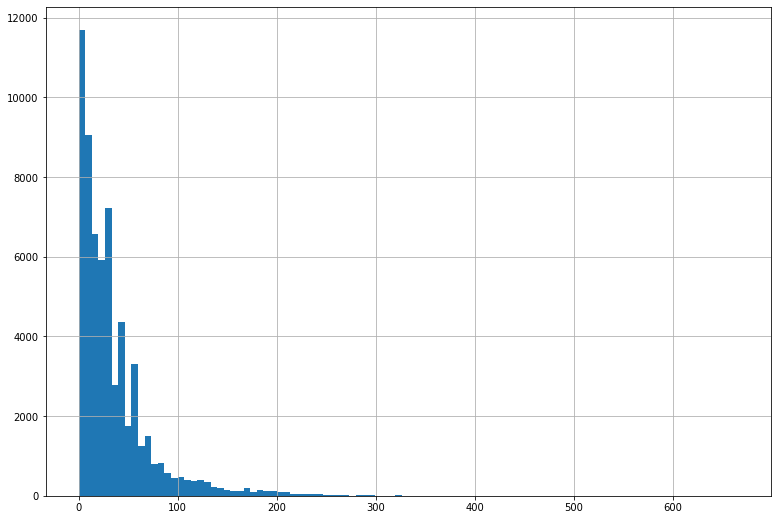

In [32]:
# распределение фактических сроков пользования займом
display(real_term['real_term'].describe())
real_term['real_term'].hist(bins=100, figsize=(13, 9));

In [33]:
# ТОП10 запрашиваемых сроков
real_term['term'].value_counts().head(10)

30    16947
40     7639
56     4966
10     4943
20     4238
16     3647
23     2681
42     2468
12     1727
15     1129
Name: term, dtype: int64

In [34]:
# ТОП10 фактических сроков
real_term['real_term'].value_counts().head(10)

0     2139
1     2134
30    1953
56    1934
42    1766
10    1721
2     1707
3     1598
28    1566
4     1439
Name: real_term, dtype: int64

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> графики распределения отличаются очень сильно. Это говорит о том, что то, как люди планируют возвращать деньги и то, как они их возвращают - это разные значения
        <li> также на распределение оказывает влияение то, что запрашиваемый срок займа строго ограничен
        <li> среднее значение фактического пользования займом = 34.75 дня, средний запрашиваемый срок = 28.78 дня
        <li> медианное значение больше уже у запрашиваемых показателй - 30 дней против 23 дней. Т.е. 50% займов закрываются в срок до 23 дней
        <li> в ТОП10 значений фактического пользования займами 50% значений находится в диапазоне от 0 до 4 дней
        <li> 25% займов погашаются до 10 дней, 50% до 23 дней, 75% до 43 дней. Над этими показателями стоило бы поработать
    </ul>
</div>

#### 3.3 Динамка планового и фактического срока пользования деньгами

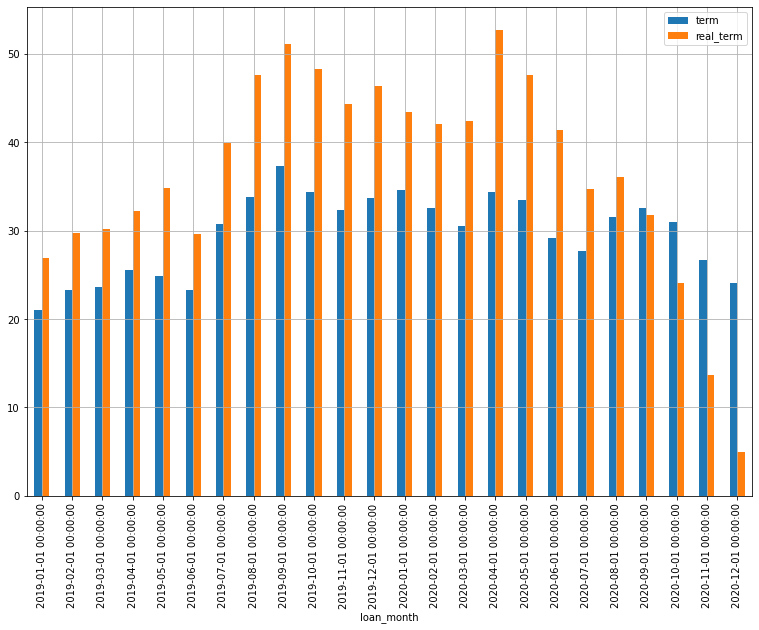

In [35]:
real_term.groupby('loan_month').agg({'term': 'mean', 'real_term': 'mean'}).plot(kind='bar', figsize=(13, 9), grid=True);

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> весь 2019 год средний срок пользовния деньгами показывал положительную динамику
        <li> в этот же период мы видим значительно большой рост факт.пользования отностилеьно плана
        <li> начиная с июля график идет вниз, но это скорее всего связано с тем, что часть клиентов из просрочки еще не вернули деньги (но согласно статистике обязательно вернут) либо доля досрочных погашений выросла
        <li> в дальнейшем посомотрим еще на эти показатели в когортах
    </ul>
</div>

### 4. Категоризация займов по реальному сроку пользования деньгами

In [36]:
# созданим функцию категоризации срока закрытия займа
def set_term_category(row):
    if row['real_term'] == row['term']:
        return 'В срок'
    elif row['real_term'] < row['term']:
        return 'Досрочно'
    elif row['real_term'] > row['term']:
        return 'С просрочкой'
    return 'Не закрыт'

In [37]:
# применяем функцию
loans['term_category'] = loans.apply(set_term_category, axis=1)

# проверяем
loans.sample(10)

,cid,start_date,value,term,status,end_date,loan_month,real_term,term_category
10408,924803,2019-02-28,12000.0,30,Погашен,2019-03-09,2019-02-01,9.0,Досрочно
14502,941641,2019-04-10,12000.0,30,Погашен,2019-04-12,2019-04-01,2.0,Досрочно
55002,1189956,2019-07-30,18190.0,40,Просрочен,NaT,2019-07-01,NaN,Не закрыт
1790,893751,2019-01-09,4000.0,20,Просрочен,NaT,2019-01-01,NaN,Не закрыт
28123,1020541,2019-03-30,6000.0,18,Погашен,2019-04-02,2019-03-01,3.0,Досрочно
66242,1249799,2019-11-21,23310.0,56,На цессии,NaT,2019-11-01,NaN,Не закрыт
68076,1264987,2019-12-10,18870.0,16,На цессии,NaT,2019-12-01,NaN,Не закрыт
7372,912867,2019-03-23,15500.0,30,На цессии,NaT,2019-03-01,NaN,Не закрыт
74265,1318558,2020-02-06,9000.0,56,Погашен,2020-04-21,2020-02-01,75.0,С просрочкой
37978,1075609,2019-05-21,3500.0,16,Погашен,2019-06-07,2019-05-01,17.0,С просрочкой


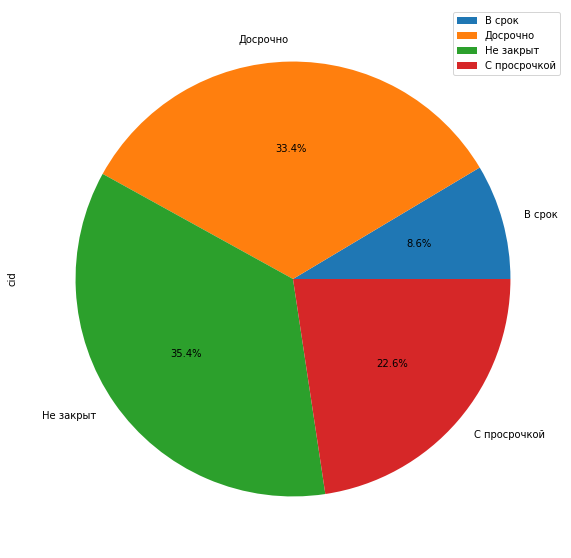

In [38]:
# построим круговую диаграмму для визуализации разделения займов по типам погашения
loans.groupby('term_category').agg({'cid': 'count'}).plot(kind='pie', subplots=True, figsize=(10, 10), autopct='%1.1f%%');

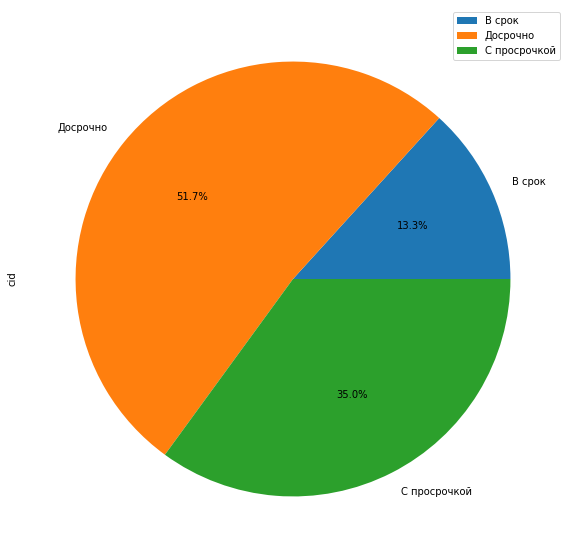

In [39]:
# та же диаграмма, но без статуса "Не закрыт"
loans.query('term_category != "Не закрыт"')\
.groupby('term_category').agg({'cid': 'count'}).plot(kind='pie', subplots=True, figsize=(10, 10), autopct='%1.1f%%');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> 35.4% не закрытых займов - цифра немного преувеличенная т.к. чем ближе анализируемый месяц к текущему - тем больше % невозвратов и наоборот.
        <li> если анализировать уже закрытые займы - 51.7% досрочно закрытых займов это большая цифра. И это как раз точка роста
    </ul>
</div>

### 4. Исследование суммы займов

#### 4.1 Базовые данные о сумме займов

In [40]:
print(f'Суммарные выдачи за анализируемый период составили {loans["value"].sum().round(0):,} рублей')

Суммарные выдачи за анализируемый период составили 986,013,282.0 рублей


In [41]:
# посмотрим на среднее, медиану, квартили и другие значения
loans['value'].describe()

count    96140.000000
mean     10256.014999
std       5882.432325
min         10.000000
25%       5000.000000
50%       9328.000000
75%      14500.000000
max      80500.000000
Name: value, dtype: float64

In [42]:
# TOP10 частотность
loans['value'].value_counts().head(10)

20000.0    5413
10000.0    5094
8000.0     4322
4000.0     3997
12000.0    3926
5000.0     3426
3500.0     2906
6500.0     2671
17000.0    2220
15000.0    2208
Name: value, dtype: int64

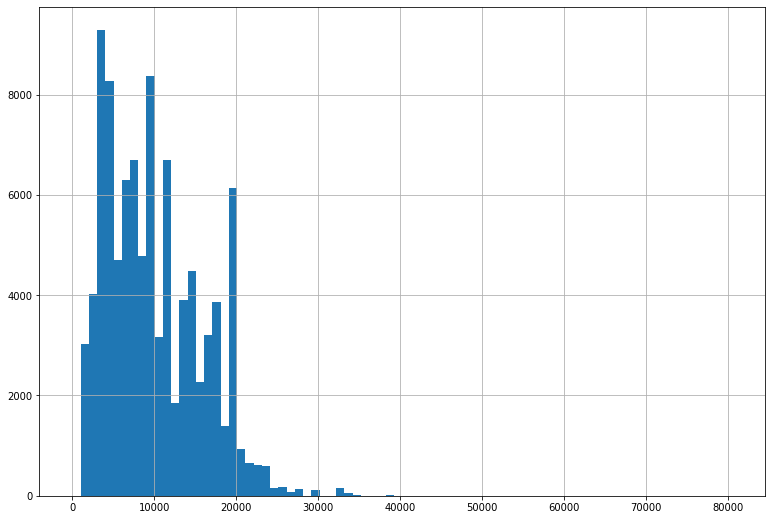

In [43]:
# посмотрим на распределение
loans['value'].hist(figsize=(13, 9), bins=80);

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> общая сумма выданных средств за анализируемый период 986 013 282 рубля
        <li> средняя выдача - 10 256 рублей
        <li> первый-третий квартили: 5000, 9328, 14500
        <li> чаще всего берут займ на 20000 рублей (5413 раз)
        <li> в ТОП10 значений по частоте 50% менее 10000 рублей
    </ul>
</div>

#### 4.2 Динамика измениня средней суммы займа

In [44]:
# группируем данные по месяцам, для каждого месяца считаем суммарный объем займов и количество займов
avg_loan_value = loans.groupby('loan_month').agg({'value': 'sum', 'cid': 'count'})

# переименуюем столбцы
avg_loan_value.columns=['total_value', 'total_loans']

# посчитаем средний чек
avg_loan_value['avg_loan_value'] = (avg_loan_value['total_value'] / avg_loan_value['total_loans']).astype('int')

avg_loan_value

,total_value,total_loans,avg_loan_value
loan_month,,,
2019-01-01,57831500.0,5487,10539
2019-02-01,76545800.0,7228,10590
2019-03-01,70695000.0,6281,11255
2019-04-01,66173710.0,5915,11187
2019-05-01,57315015.0,5058,11331
2019-06-01,33129616.0,3328,9954
2019-07-01,46900271.0,4884,9602
2019-08-01,38116003.0,3541,10764
2019-09-01,37544008.0,3090,12150


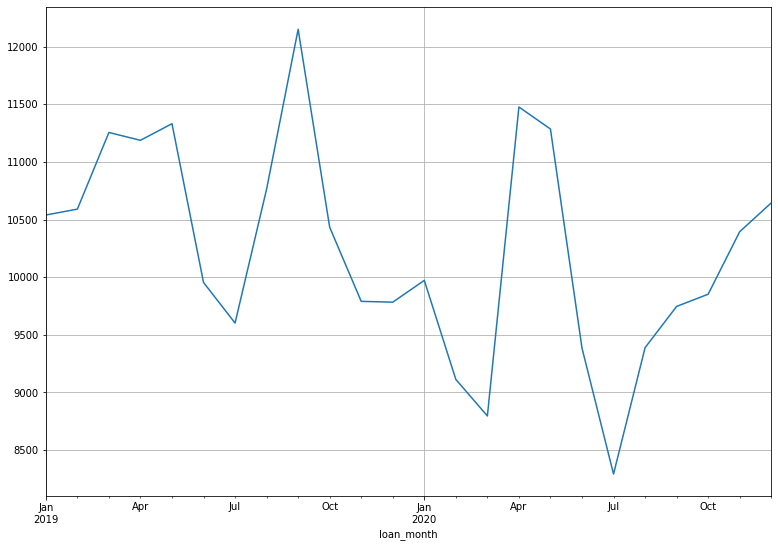

In [45]:
# посмотрим на чек в динамике
avg_loan_value['avg_loan_value'].plot(figsize=(13, 9), grid=True);

In [46]:
print(f'Минимальное занчение {avg_loan_value["avg_loan_value"].min()} рубл.')
print(f'Максимальное занчение {avg_loan_value["avg_loan_value"].max()} руб.')

Минимальное занчение 8292 рубл.
Максимальное занчение 12150 руб.


<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> мин-макс средние значения находятся в диапазоне от 8292 руб до 12150 руб
        <li> не прослеживается какой-либо тренд на рост-падение, наблюдаюется рост-падение чека на 2-3к рублей
    </ul>
</div>

### 5. Когортный анализ

#### 5.1 Ретеншен

In [47]:
# для начала нам нужно выделить в отдельную таблицу месяц первого займа для каждого пользователя
loan_first_month = loans.sort_values(by=['cid', 'loan_month']).groupby(by='cid').agg({'loan_month': 'first'}).reset_index()

# переименуем столбцы
loan_first_month.columns = ['cid', 'loan_first_month']

# смотрим на результат
loan_first_month

,cid,loan_first_month
0,888862,2019-01-01
1,888868,2019-01-01
2,888872,2019-01-01
3,888882,2019-01-01
4,888884,2019-01-01
...,...,...
53721,1476481,2020-11-01
53722,1476483,2020-11-01
53723,1476484,2020-11-01
53724,1476494,2020-11-01


In [48]:
# объеденим таблицы loans vs loan_first_month
loans = pd.merge(loans, loan_first_month, on='cid')

# добавим в таблицу столбец cohort_lifetime, который указывает на срок жизни когорты в месяцах
loans['cohort_lifetime'] =((loans['loan_month'] - loans['loan_first_month']) / np.timedelta64(1,'M'))\
.round().astype('int')

# смотрим на результат
loans.head()

,cid,start_date,value,term,status,end_date,loan_month,real_term,term_category,loan_first_month,cohort_lifetime
0,889241,2019-12-04,7215.0,40,Погашен,2019-12-17,2019-12-01,13.0,Досрочно,2019-01-01,11
1,889241,2020-01-25,21090.0,56,Погашен,2020-02-07,2020-01-01,13.0,Досрочно,2019-01-01,12
2,889241,2020-01-06,11100.0,56,Погашен,2020-01-18,2020-01-01,12.0,Досрочно,2019-01-01,12
3,889241,2020-02-23,24000.0,56,Погашен,2020-05-07,2020-02-01,74.0,С просрочкой,2019-01-01,13
4,889241,2020-02-09,24000.0,56,Погашен,2020-02-21,2020-02-01,12.0,Досрочно,2019-01-01,13


In [49]:
# создадим новую таблицу retention и сгруппируем в нее данные из таблицы loans
retention = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'cid': 'nunique'}).reset_index()

# переименуем колонки
retention.columns = ['loan_first_month', 'cohort_lifetime', 'active_users']

# смотрим результат
retention

,loan_first_month,cohort_lifetime,active_users
0,2019-01-01,0,4575
1,2019-01-01,1,1197
2,2019-01-01,2,717
3,2019-01-01,3,412
4,2019-01-01,4,252
...,...,...,...
295,2020-10-01,1,621
296,2020-10-01,2,376
297,2020-11-01,0,3848
298,2020-11-01,1,406


In [50]:
# теперь в отдельной таблице сохраним пользователей нулевой когорты
initial_users = retention[retention['cohort_lifetime'] == 0][['loan_first_month', 'active_users']]

# переименуем столбцы
initial_users.columns = ['loan_first_month', 'initial_users']

# смотрим результат
initial_users

,loan_first_month,initial_users
0,2019-01-01,4575
24,2019-02-01,5018
47,2019-03-01,3007
69,2019-04-01,3092
90,2019-05-01,2520
110,2019-06-01,1421
129,2019-07-01,3264
147,2019-08-01,1878
164,2019-09-01,1366
180,2019-10-01,1319


In [51]:
# добавим в таблицу retention столбец initial_users из таблицы initial_users
retention = pd.merge(retention, initial_users, on='loan_first_month')

# рассчитаем retention_rate
retention['retention_rate'] = retention['active_users'] / retention['initial_users']

# смотрим финальную таблицу
retention.head()

,loan_first_month,cohort_lifetime,active_users,initial_users,retention_rate
0,2019-01-01,0,4575,4575,1.000000
1,2019-01-01,1,1197,4575,0.261639
2,2019-01-01,2,717,4575,0.156721
3,2019-01-01,3,412,4575,0.090055
4,2019-01-01,4,252,4575,0.055082


In [52]:
# группируем все в сводную таблицу
retention_pivot = retention.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                                        values='retention_rate', aggfunc='sum')

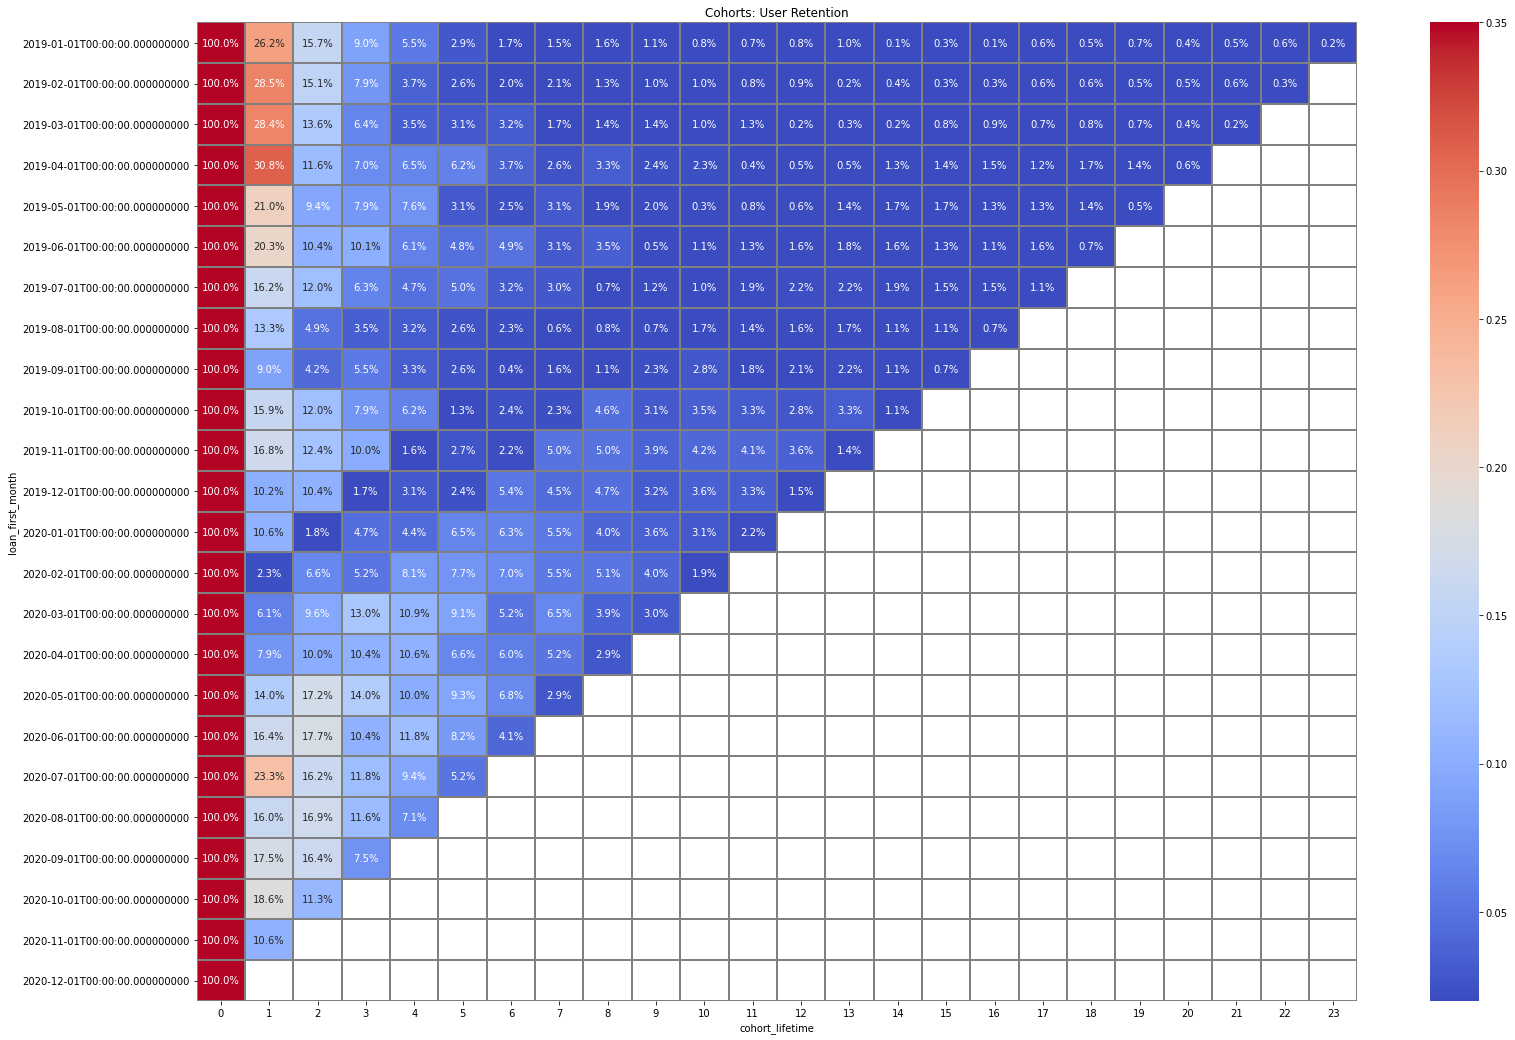

In [53]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmax=0.35, vmin=0.02);

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> выводы будут после анализа лайма
    </ul>
</div>

#### 5.2 Среднее кол-во займов

In [54]:
avg_loan_amount = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'cid': 'count'}).reset_index()
avg_loan_amount.rename(columns={'cid': 'cumsum_loans'}, inplace=True)
avg_loan_amount = pd.merge(avg_loan_amount, initial_users, on='loan_first_month')
avg_loan_amount['avg_loans'] = (avg_loan_amount['cumsum_loans'] / avg_loan_amount['initial_users']).round(2)

avg_loan_amount.head()

,loan_first_month,cohort_lifetime,cumsum_loans,initial_users,avg_loans
0,2019-01-01,0,5487,4575,1.20
1,2019-01-01,1,1438,4575,0.31
2,2019-01-01,2,844,4575,0.18
3,2019-01-01,3,493,4575,0.11
4,2019-01-01,4,293,4575,0.06


In [55]:
avg_loan_pivot = avg_loan_amount.pivot_table(index='loan_first_month', columns='cohort_lifetime', values='avg_loans', aggfunc='mean').cumsum(axis=1)

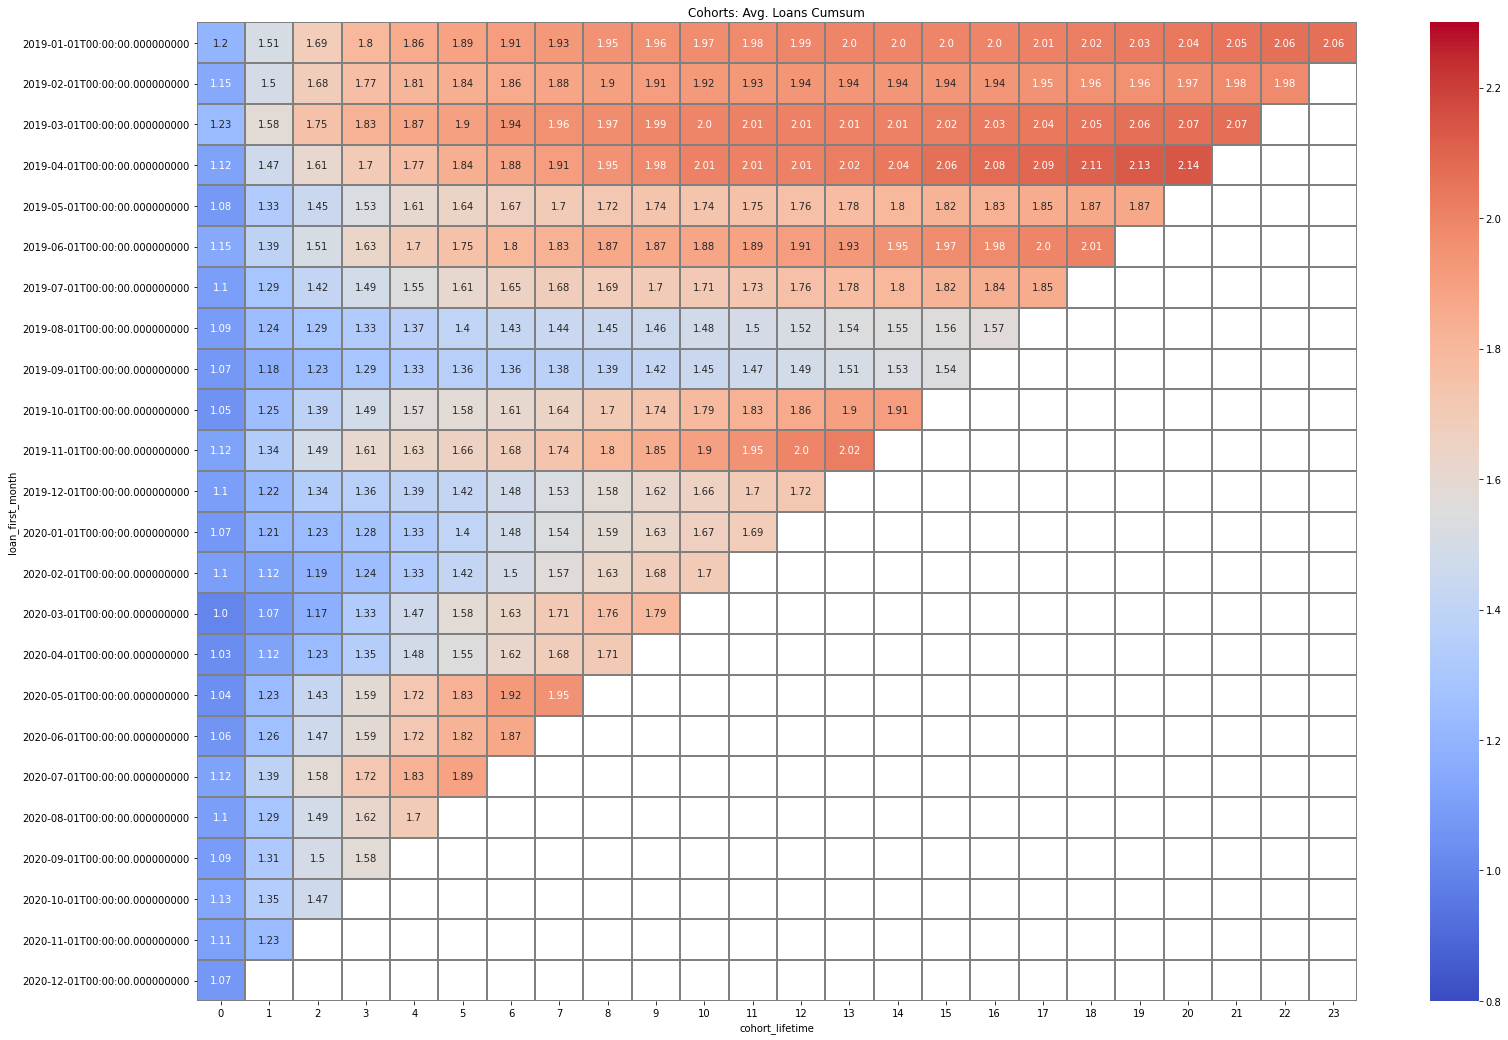

In [56]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: Avg. Loans Cumsum')
sns.heatmap(avg_loan_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=0.8, vmax=2.3);

#### 5.3 ARPU (Average Revenue per User)

In [57]:
arpu = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum'}).reset_index()
arpu = pd.merge(arpu, initial_users, on='loan_first_month')
arpu['arpu'] = ((arpu['value'] / arpu['initial_users'])/1000).round(2)

arpu.head()

,loan_first_month,cohort_lifetime,value,initial_users,arpu
0,2019-01-01,0,57831500.0,4575,12.64
1,2019-01-01,1,17557400.0,4575,3.84
2,2019-01-01,2,11284000.0,4575,2.47
3,2019-01-01,3,6581100.0,4575,1.44
4,2019-01-01,4,3968690.8,4575,0.87


In [58]:
arpu_pivot = arpu.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                              values='arpu', aggfunc='mean').cumsum(axis=1)

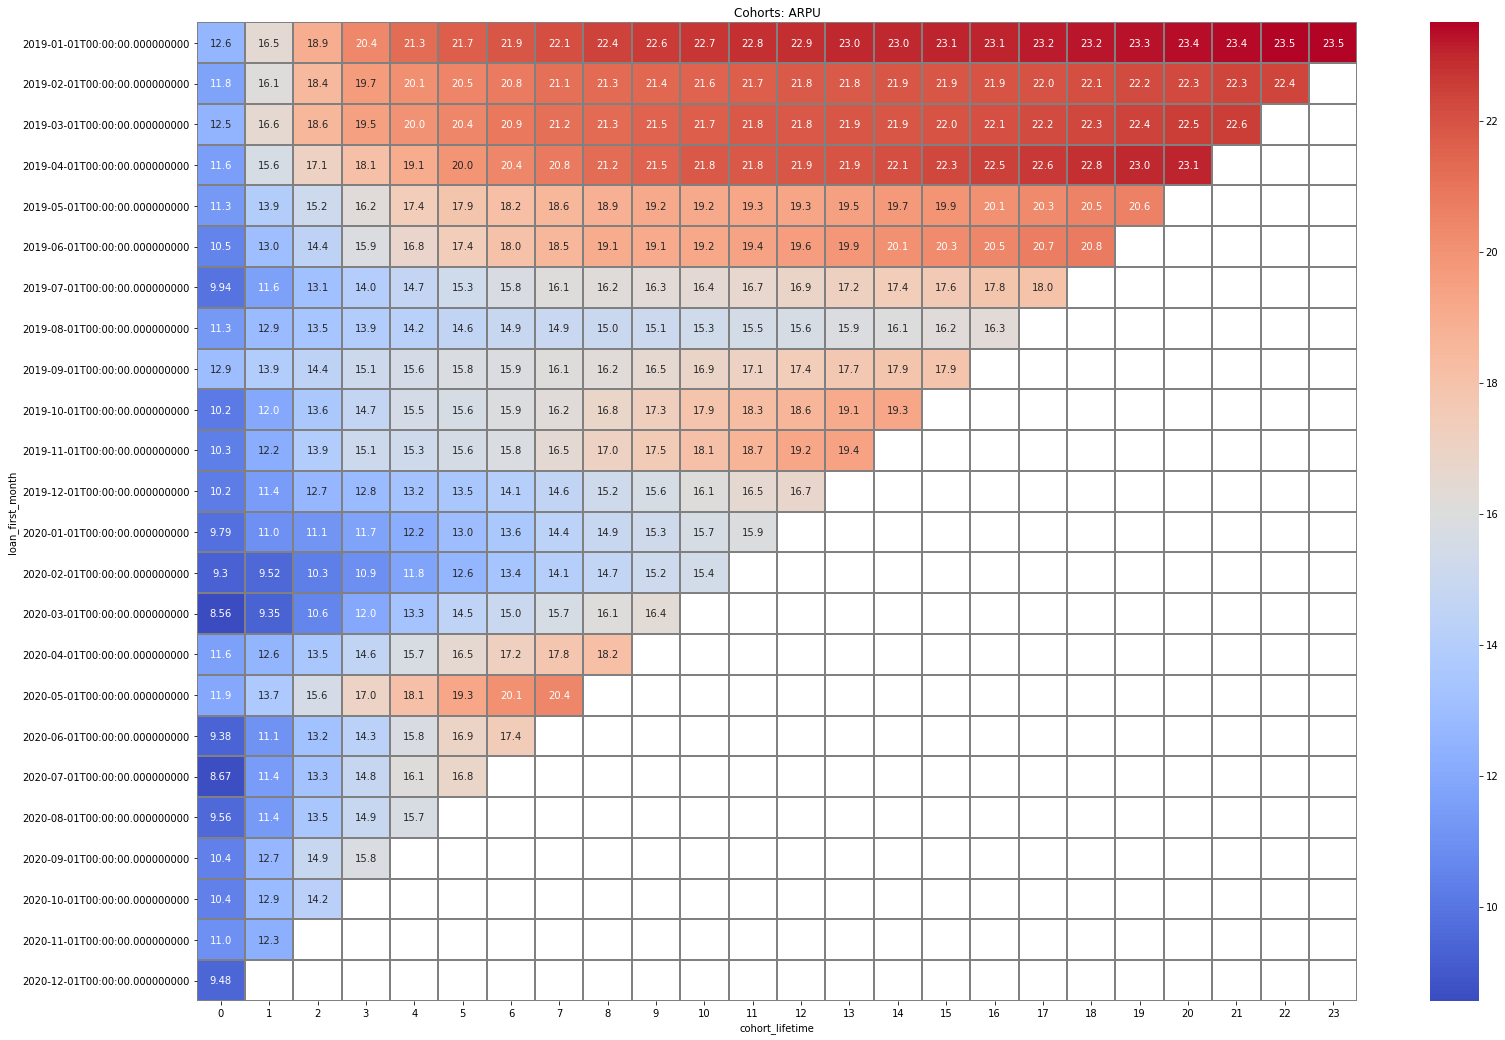

In [59]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: ARPU')
sns.heatmap(arpu_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm');

#### 5.4 Средняя сумма займа в конкретный месяц
почему с ростом lifetime "чек" не растет?

In [60]:
avg_loan_value = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum', 'cid': 'count'}).reset_index()
avg_loan_value['avg_loan_value'] = ((avg_loan_value['value'] / avg_loan_value['cid'])/1000).round(2)

avg_loan_value.head()

,loan_first_month,cohort_lifetime,value,cid,avg_loan_value
0,2019-01-01,0,57831500.0,5487,10.54
1,2019-01-01,1,17557400.0,1438,12.21
2,2019-01-01,2,11284000.0,844,13.37
3,2019-01-01,3,6581100.0,493,13.35
4,2019-01-01,4,3968690.8,293,13.55


In [61]:
avg_loan_value_pivot = avg_loan_value.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                              values='avg_loan_value', aggfunc='mean')

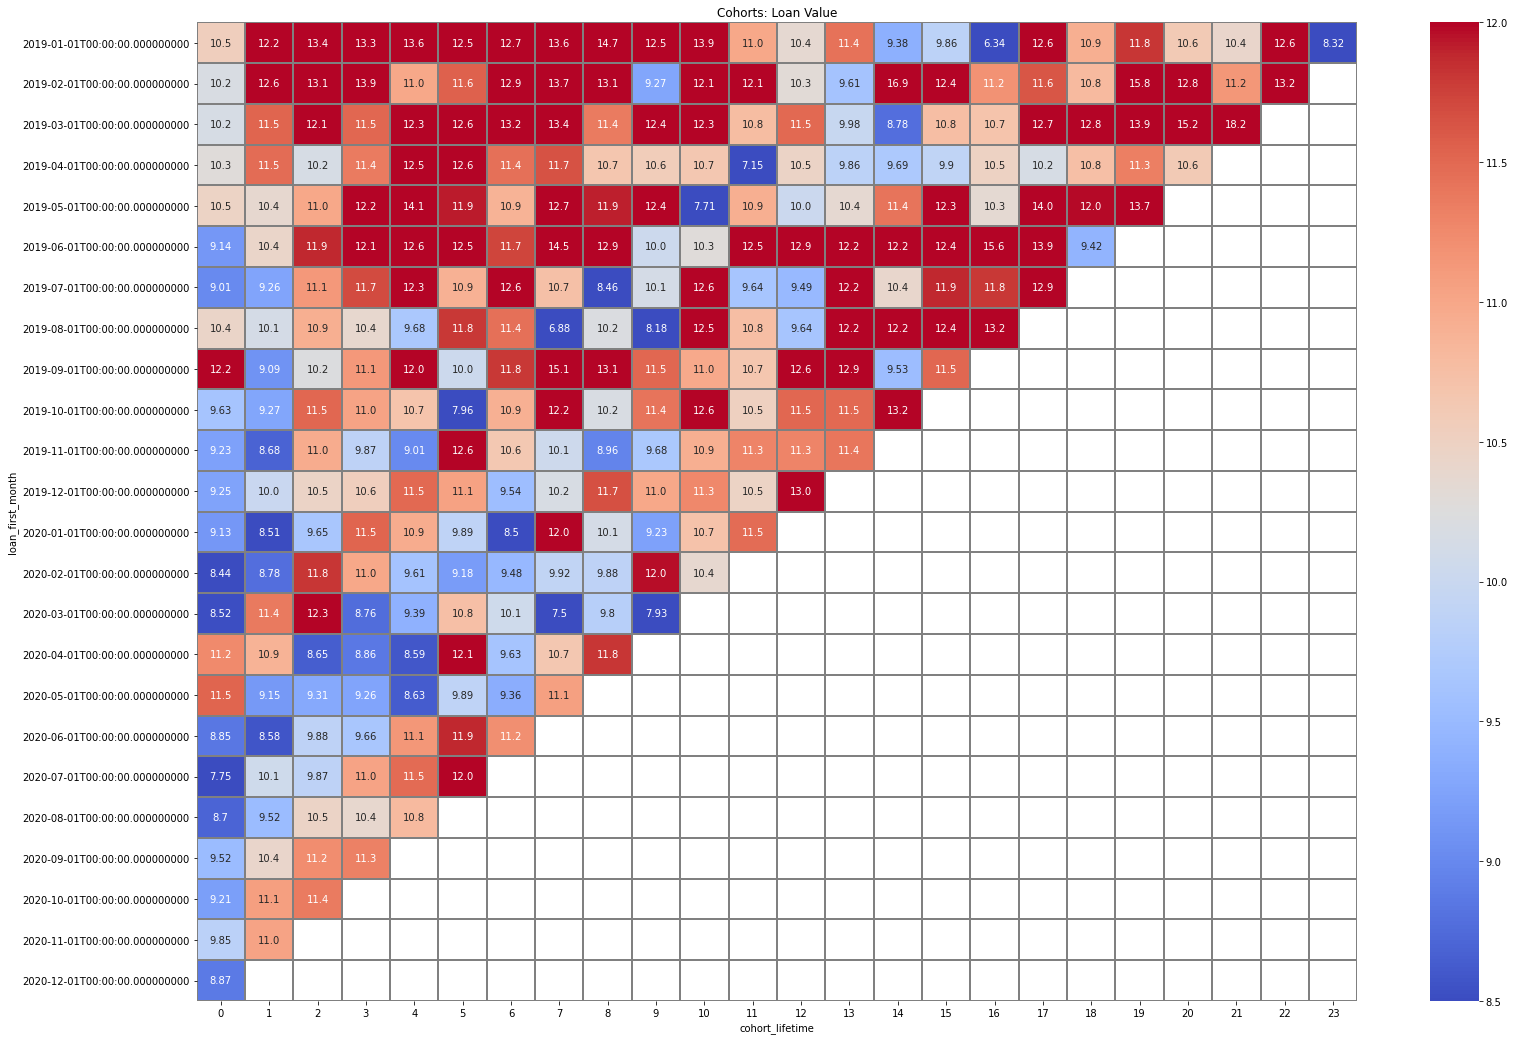

In [62]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: Loan Value')
sns.heatmap(avg_loan_value_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=8.5, vmax=12);

#### 5.4 Средняя сумма займа накопительным итогом

In [63]:
avg_cumsum_loan_value = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum', 'cid': 'count'})\
.groupby(level=0).cumsum().reset_index()
avg_cumsum_loan_value.rename(columns={'value': 'cumsum_value', 'cid': 'cumsum_loans'}, inplace=True)
avg_cumsum_loan_value['avg_cumsum_loan_value'] = ((avg_cumsum_loan_value['cumsum_value'] / avg_cumsum_loan_value['cumsum_loans'])/1000).round(2)

avg_cumsum_loan_value.head()

,loan_first_month,cohort_lifetime,cumsum_value,cumsum_loans,avg_cumsum_loan_value
0,2019-01-01,0,57831500.0,5487,10.54
1,2019-01-01,1,75388900.0,6925,10.89
2,2019-01-01,2,86672900.0,7769,11.16
3,2019-01-01,3,93254000.0,8262,11.29
4,2019-01-01,4,97222690.8,8555,11.36


In [64]:
avg_cumsum_loan_pivot = avg_cumsum_loan_value.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                              values='avg_cumsum_loan_value', aggfunc='mean')

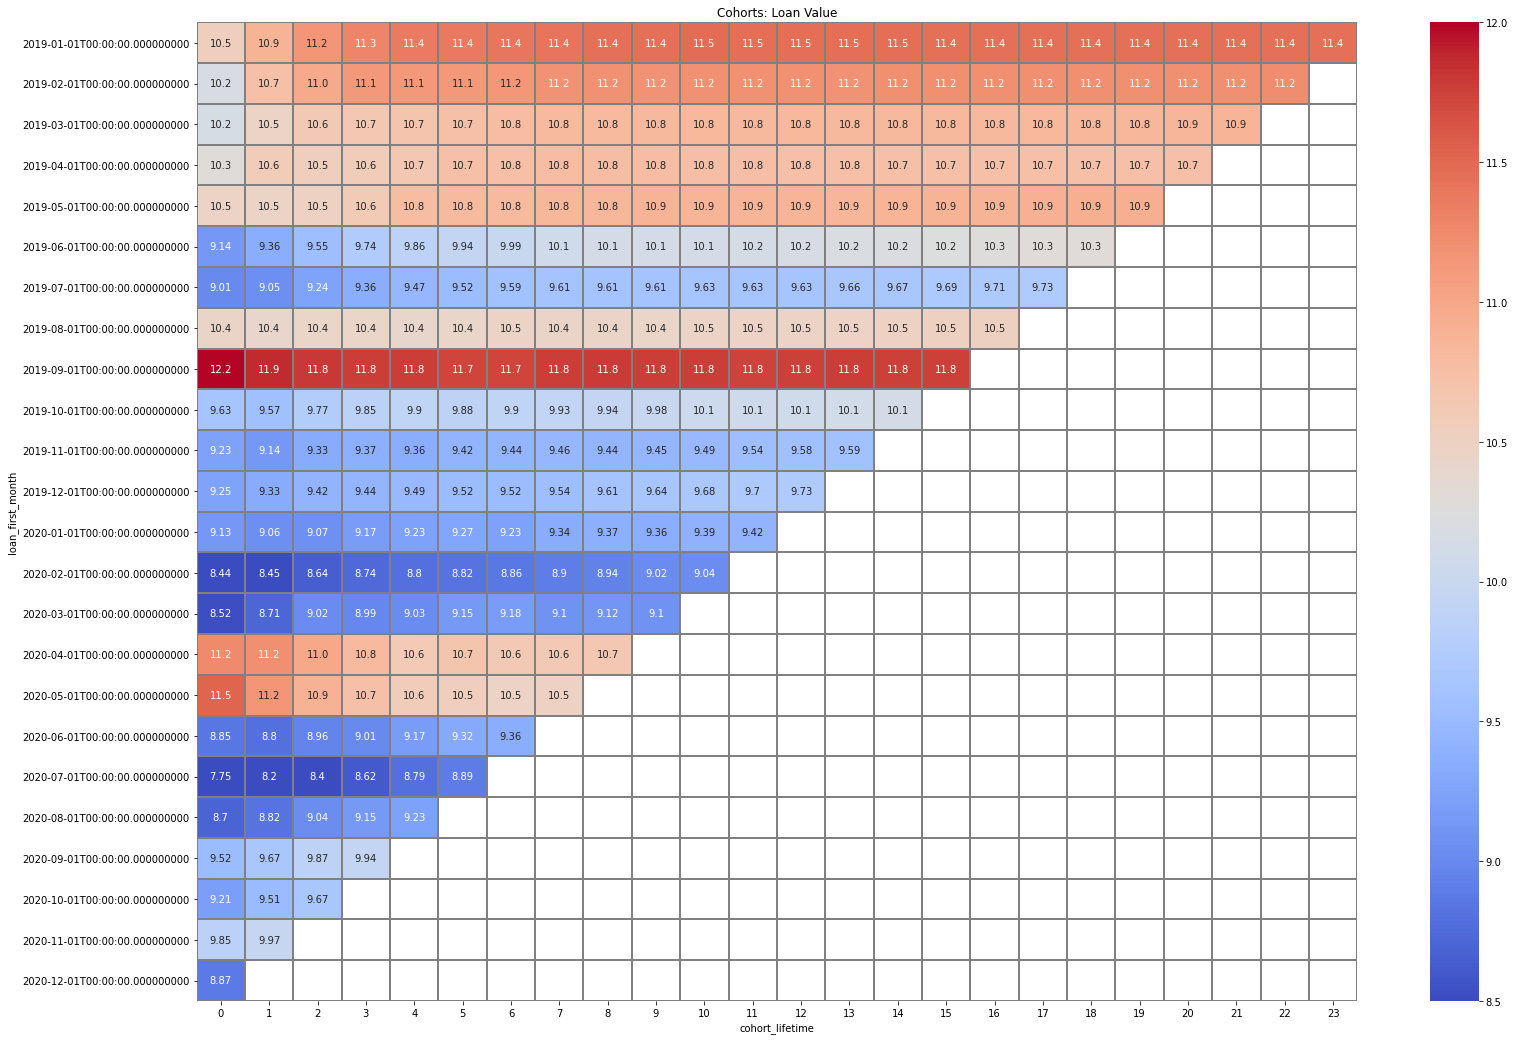

In [65]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: Loan Value')
sns.heatmap(avg_cumsum_loan_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=8.5, vmax=12);

#### 5.5 Оборотка нарастающим итогом

In [66]:
cumsum_value = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum', }).reset_index()
cumsum_value['value'] = (cumsum_value['value'] / 10000000).round(2)

cumsum_value

,loan_first_month,cohort_lifetime,value
0,2019-01-01,0,5.78
1,2019-01-01,1,1.76
2,2019-01-01,2,1.13
3,2019-01-01,3,0.66
4,2019-01-01,4,0.40
...,...,...,...
295,2020-10-01,1,0.82
296,2020-10-01,2,0.46
297,2020-11-01,0,4.22
298,2020-11-01,1,0.51


In [67]:
initial_value = cumsum_value[cumsum_value['cohort_lifetime'] == 0][['loan_first_month', 'value']]
initial_value.columns=['loan_first_month', 'initial_value']
initial_value

,loan_first_month,initial_value
0,2019-01-01,5.78
24,2019-02-01,5.90
47,2019-03-01,3.75
69,2019-04-01,3.58
90,2019-05-01,2.85
110,2019-06-01,1.50
129,2019-07-01,3.25
147,2019-08-01,2.13
164,2019-09-01,1.77
180,2019-10-01,1.34


In [68]:
cumsum_value = pd.merge(cumsum_value, initial_value, on='loan_first_month')
cumsum_value['value_gain'] = cumsum_value['value'] / cumsum_value['initial_value']

cumsum_value.head(20)

,loan_first_month,cohort_lifetime,value,initial_value,value_gain
0,2019-01-01,0,5.78,5.78,1.000000
1,2019-01-01,1,1.76,5.78,0.304498
2,2019-01-01,2,1.13,5.78,0.195502
3,2019-01-01,3,0.66,5.78,0.114187
4,2019-01-01,4,0.40,5.78,0.069204
5,2019-01-01,5,0.19,5.78,0.032872
6,2019-01-01,6,0.12,5.78,0.020761
7,2019-01-01,7,0.10,5.78,0.017301
8,2019-01-01,8,0.12,5.78,0.020761
9,2019-01-01,9,0.07,5.78,0.012111


In [69]:
cumsum_value_pivot = cumsum_value.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                         values='value_gain', aggfunc='mean').cumsum(axis=1)

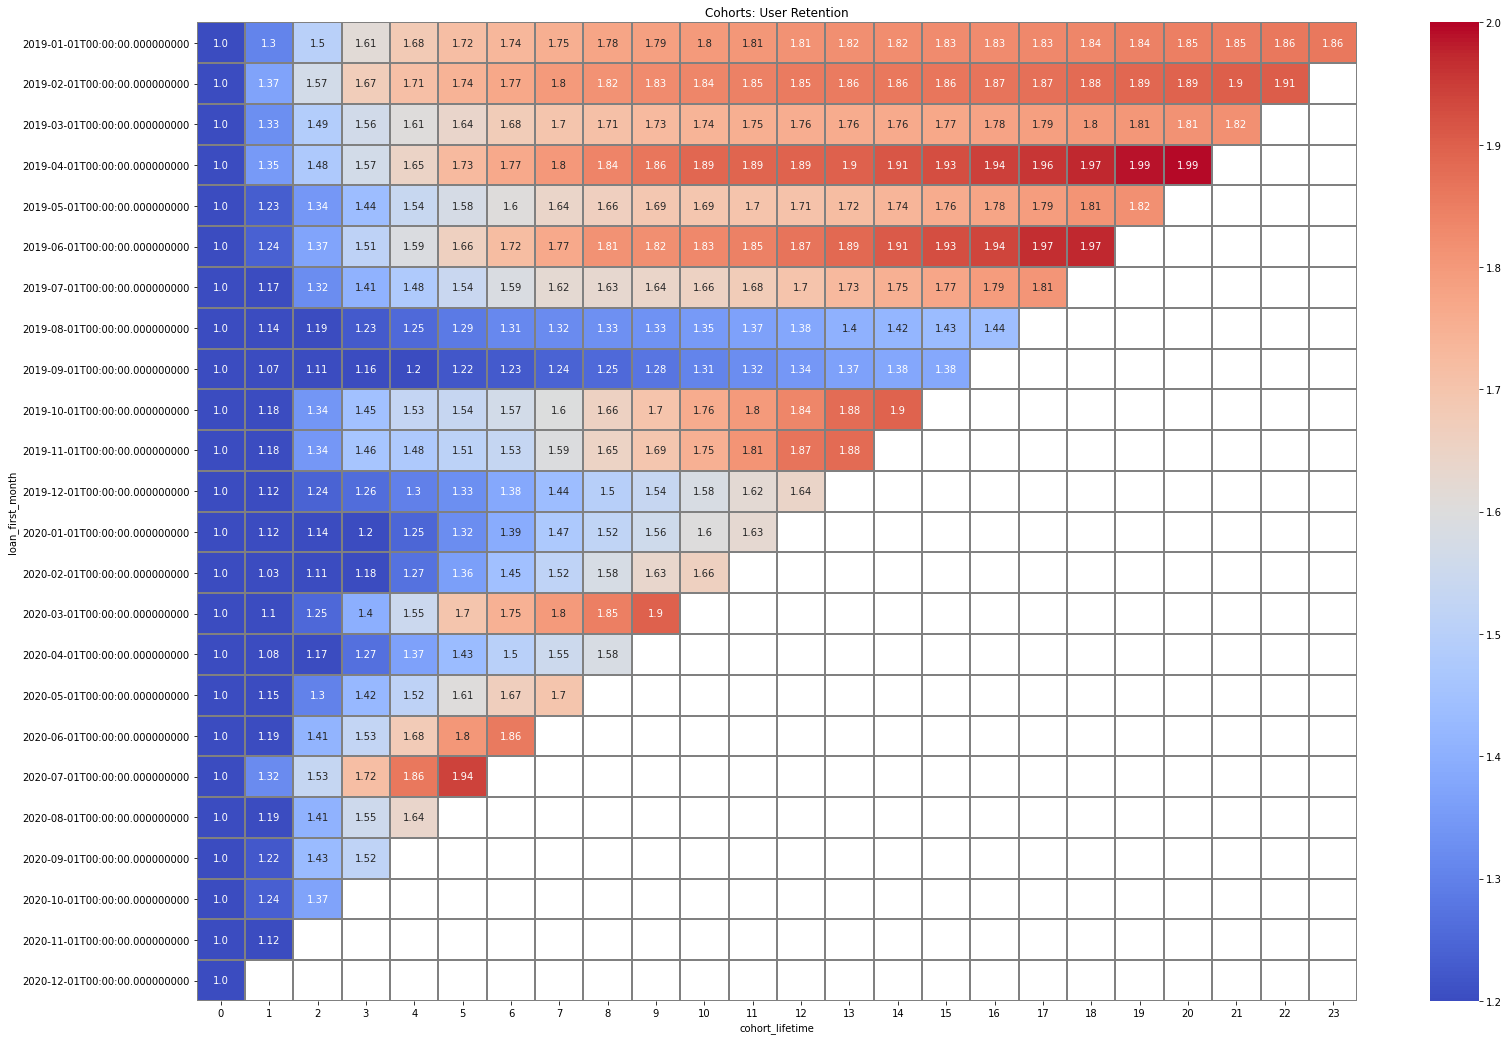

In [70]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: User Retention')
sns.heatmap(cumsum_value_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=1.2, vmax=2);

In [71]:
loans['end_month'] = loans['end_date'].astype('datetime64[M]')
loans.head()

,cid,start_date,value,term,status,end_date,loan_month,real_term,term_category,loan_first_month,cohort_lifetime,end_month
0,889241,2019-12-04,7215.0,40,Погашен,2019-12-17,2019-12-01,13.0,Досрочно,2019-01-01,11,2019-12-01
1,889241,2020-01-25,21090.0,56,Погашен,2020-02-07,2020-01-01,13.0,Досрочно,2019-01-01,12,2020-02-01
2,889241,2020-01-06,11100.0,56,Погашен,2020-01-18,2020-01-01,12.0,Досрочно,2019-01-01,12,2020-01-01
3,889241,2020-02-23,24000.0,56,Погашен,2020-05-07,2020-02-01,74.0,С просрочкой,2019-01-01,13,2020-05-01
4,889241,2020-02-09,24000.0,56,Погашен,2020-02-21,2020-02-01,12.0,Досрочно,2019-01-01,13,2020-02-01


In [72]:
get_loans = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'cid': 'count'}).groupby(level=0).cumsum().reset_index()
get_loans.rename(columns={'cid': 'get_loans'}, inplace=True)
get_loans.head()

,loan_first_month,cohort_lifetime,get_loans
0,2019-01-01,0,5487
1,2019-01-01,1,6925
2,2019-01-01,2,7769
3,2019-01-01,3,8262
4,2019-01-01,4,8555


In [73]:
paid_loans = loans.groupby(['loan_first_month', 'end_month']).agg({'cid': 'count'}).groupby(level=0).cumsum().reset_index()
paid_loans['cohort_lifetime'] = ((paid_loans['end_month'] - paid_loans['loan_first_month']) / np.timedelta64(1,'M')).round().astype('int')
paid_loans.drop(columns='end_month', inplace=True)
paid_loans = paid_loans[['loan_first_month', 'cohort_lifetime', 'cid']]
paid_loans.rename(columns={'cid': 'paid_loans'}, inplace=True)

paid_loans.head()

,loan_first_month,cohort_lifetime,paid_loans
0,2019-01-01,0,1360
1,2019-01-01,1,3279
2,2019-01-01,2,4283
3,2019-01-01,3,4861
4,2019-01-01,4,5184


In [74]:
output = pd.merge(get_loans, paid_loans, on=['loan_first_month', 'cohort_lifetime'])
output['r_rate'] = (output['paid_loans'] / output['get_loans'])
output_pivot = output.pivot_table(index='loan_first_month', columns='cohort_lifetime', values='r_rate')

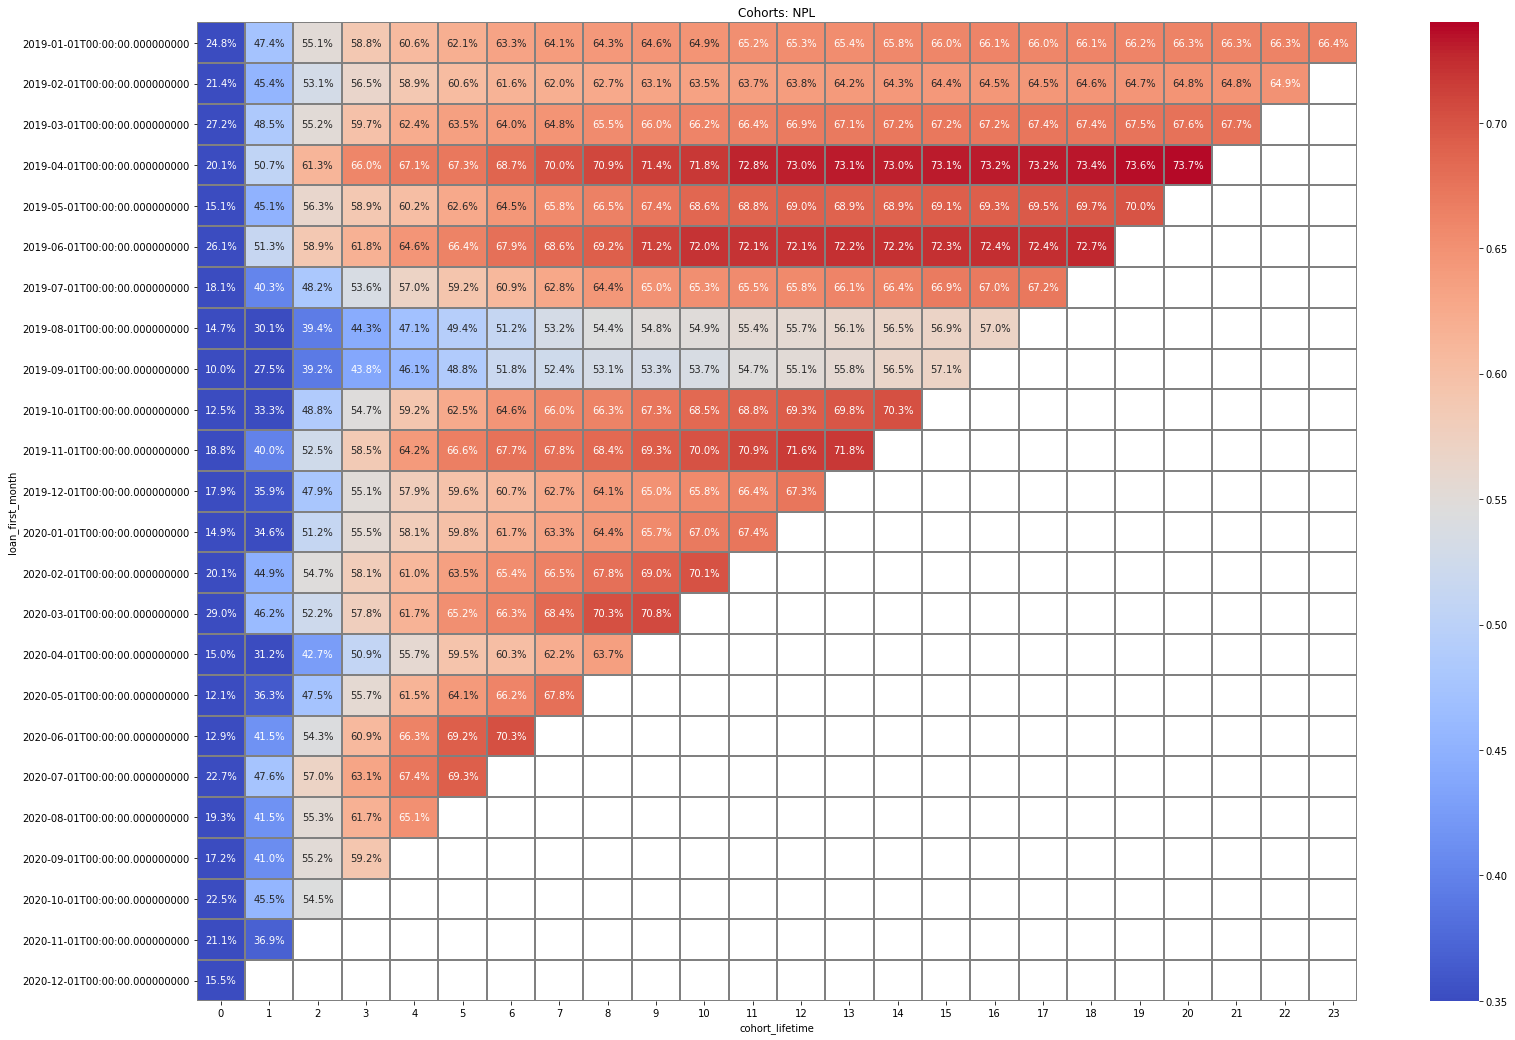

In [75]:
##### Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: NPL')
sns.heatmap(output_pivot, annot=True, fmt='.1%', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=0.35, vmax=0.74);